# 데이터 정제 - 이상치(outlier), 중복치(duplicate)

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

tips = sns.load_dataset('tips') # Seaborn 내장 'tips' 데이터셋 로드
print(tips.head())

   total_bill   tip     sex smoker  day    time  size
0       16.99  1.01  Female     No  Sun  Dinner     2
1       10.34  1.66    Male     No  Sun  Dinner     3
2       21.01  3.50    Male     No  Sun  Dinner     3
3       23.68  3.31    Male     No  Sun  Dinner     2
4       24.59  3.61  Female     No  Sun  Dinner     4


## 1) 이상치 탐지
- 시각적 탐지(박스플롯 활용) cf) 이외에도 산점도(scatter plot)-2차원 이상치, 히스토그램(histgram)-극단값 확인으로 이상치 탐지 가능!
- 수치 기반 탐지(IQR, Z-score)
  * IQR: Q1-1.5*IQR 보다 작고, Q3+1.5*IQR 보다 크면 이상치 간주
  * Z-score: 정규분포를 따른다고 가정할 때, 각 데이터가 평균으로부터 표준편차의 몇 배만큼 떨어져 있는지 나타낸 값(z=(x-평균)/표준편차), 평균으로부터 3표준편차(분포의 약 99.7% 포함) 이상을 이상치로 정의(|Z|>3)
  * 이상치 기준 설정: modified Z-score(MAD), Histogram-based Outlier Score(HBOS)
  * PyOD(Python Outlier Detection) 등 라이브러리 사용
- 기타 탐지 기반(통계적 분석 목적) ex) 신용카드 사기 탐지, 질병 진단 등
  * 머신러닝 기반 탐지: Isolation Forest(Random Forest 기반), DBSCAN(밀도 기반 클러스터링), Local Outlier Factor(LOF, 주변 데이터와의 밀도 비교), One-Class SVM, CNN 기반

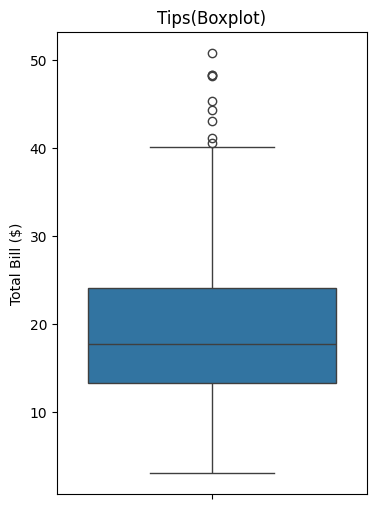

In [2]:
# 박스플롯(boxplot)
plt.figure(figsize=(4,6))
sns.boxplot(y=tips['total_bill'])
plt.title('Tips(Boxplot)')
plt.ylabel('Total Bill ($)')
plt.show()

In [3]:
# IQR(Interquartile Range) 기반 방법
Q1 = tips['total_bill'].quantile(0.25)
Q3 = tips['total_bill'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
outliers = tips[(tips['total_bill'] < lower_bound) | (tips['total_bill'] > upper_bound)]

print(f"이상치 개수: {outliers.shape[0]}")
print(outliers['total_bill'])

이상치 개수: 9
59     48.27
102    44.30
142    41.19
156    48.17
170    50.81
182    45.35
184    40.55
197    43.11
212    48.33
Name: total_bill, dtype: float64


In [4]:
# Z-점수(Z-score) 방법
mean = tips['total_bill'].mean()
std = tips['total_bill'].std()
threshold = 3 # 임계값(3표준편차)

z_scores = (tips['total_bill'] - mean) / std
outliers_z = tips[np.abs(z_scores) > threshold] # 절대값

print(f"이상치 개수: {outliers_z.shape[0]}")
print(outliers_z['total_bill'])

이상치 개수: 4
59     48.27
156    48.17
170    50.81
212    48.33
Name: total_bill, dtype: float64


## 2) 이상치 제거(removal): 데이터 삭제
- 단순 제거(IQR 기준)
- Z-점수 기반 필터링

In [7]:
# IQR 기준으로 이상치 제거
tips_clean = tips[(tips['total_bill'] >= lower_bound) & (tips['total_bill'] <= upper_bound)]

print(tips.shape, '->', tips_clean.shape)
print('원래 평균:', tips['total_bill'].mean())
print('제거 후 평균:', tips_clean['total_bill'].mean())
print('원래 중앙값:', tips['total_bill'].median())
print('제거 후 평균:', tips_clean['total_bill'].median())

(244, 7) -> (235, 7)
원래 평균: 19.78594262295082
제거 후 평균: 18.798680851063832
원래 중앙값: 17.795
제거 후 평균: 17.46


In [6]:
# Z-점수 기준으로 이상치 제거
threshold = 3
z_scores = (tips['total_bill'] - mean) / std
tips_clean_z = tips[np.abs(z_scores) <= threshold]

print(tips.shape, '->', tips_clean_z.shape)
print('원래 평균:', tips['total_bill'].mean())
print('제거 후 평균:', tips_clean_z['total_bill'].mean())
print('원래 중앙값:', tips['total_bill'].median())

(244, 7) -> (240, 7)
원래 평균: 19.78594262295082
제거 후 평균: 19.30079166666667
원래 중앙값: 17.795


## 3) 이상치 변환(transformation): 데이터 변형
- RobustScaler를 통한 스케일링(scaling): 이상치를 유지하면서 전체 데이터의 값을 변환하여 이상치 영향 줄일 수 있음(개별 값 크기보다 분포 상의 특성이 중요한 경우)
  * Sklearn 패키지에 포함된 강건 스케일러: 변수의 중앙값을 0으로 이동(중앙화) -> 각 값을 가분위수범위(IQR)로 나눔

In [10]:
# RobustScaler 적용
from sklearn.preprocessing import RobustScaler

X = tips[['total_bill', 'tip']]
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)

print('원본 5개:\n', X.head())
print('스케일 후 5개:\n', X_scaled[:5])

원본 5개:
    total_bill   tip
0       16.99  1.01
1       10.34  1.66
2       21.01  3.50
3       23.68  3.31
4       24.59  3.61
스케일 후 5개:
 [[-0.07467532 -1.2096    ]
 [-0.69155844 -0.7936    ]
 [ 0.29823748  0.384     ]
 [ 0.54591837  0.2624    ]
 [ 0.63033395  0.4544    ]]


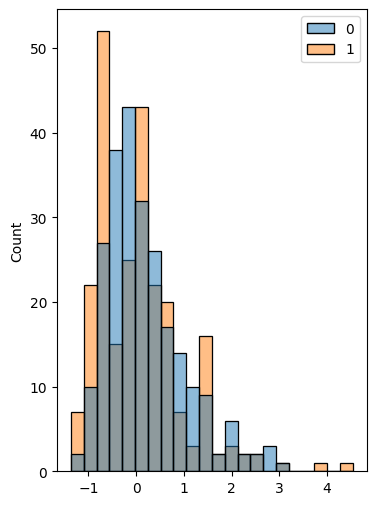

In [20]:
# 히스토그램 그려보기
plt.figure(figsize=(4,6))
sns.histplot(X_scaled)
plt.show()

## 4) 중복 데이터 처리: 동일한 행이 데이터셋에 반복해서 나타나는 경우

In [25]:
# 중복 데이터 처리
data = {'Name': ['Kim', 'Lee', 'Lee', 'Choi'],
        'Score': [90, 85, 85, 95]}
df = pd.DataFrame(data)
print(df)

   Name  Score
0   Kim     90
1   Lee     85
2   Lee     85
3  Choi     95


In [26]:
# 중복 확인
print(df.duplicated())

0    False
1    False
2     True
3    False
dtype: bool


In [27]:
# 중복 제거
df_no_dup = df.drop_duplicates() # 다른 변수로 저장
print(df_no_dup)

   Name  Score
0   Kim     90
1   Lee     85
3  Choi     95


In [28]:
# 중복 제거
print(df)
df.drop_duplicates(inplace=True) # 원본에서 바로 제거
print(df)

   Name  Score
0   Kim     90
1   Lee     85
2   Lee     85
3  Choi     95
   Name  Score
0   Kim     90
1   Lee     85
3  Choi     95


In [29]:
# reset_index(drop=True)